<h1>Data Cleaning

In [67]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [68]:
import pandas as pd
import sqlite3
from tqdm import tqdm

con = sqlite3.connect('../kickstarter.db')
for chunk in tqdm(pd.read_sql(sql="SELECT * FROM meta", con=con, chunksize=-1)):
    break
chunk = chunk.convert_dtypes()
chunk.describe(include='all')

0it [00:00, ?it/s]


,id,href,name,blurb,goal,pledged,state,slug,disable_communication,country,...,profile_feature_image_attributes_image_urls_baseball_card,urls_web_project,urls_web_rewards,profile_feature_image_attributes_id,profile_background_image_attributes_id,profile_background_image_attributes_image_urls_default,profile_background_image_attributes_image_urls_baseball_card,percent_funded,is_liked,is_disliked
count,39372,39372,39372,39372,39372.0,39372.0,39372,39372,39372.0,39372,...,39372,39372,39372,2631.0,3810.0,3810,3810,2748.0,2748.0,2748.0
unique,39372,39372,39256,38111,<NA>,<NA>,5,39372,<NA>,25,...,39366,39372,39372,<NA>,<NA>,3810,3810,<NA>,<NA>,<NA>
top,UHJvamVjdC03NTAyOTMwNDk=,https://www.kickstarter.com/projects/-sayjo/da...,Quest Repertoire: Roll the Dice and Create Que...,"3D Printable STL Files, Terrain for Tabletop, ...",<NA>,<NA>,successful,dark-village-3d-models-for-3d-printer,<NA>,US,...,https://ksr-ugc.imgix.net/missing_project_phot...,https://www.kickstarter.com/projects/-sayjo/da...,https://www.kickstarter.com/projects/-sayjo/da...,<NA>,<NA>,https://ksr-ugc.imgix.net/assets/038/701/139/e...,https://ksr-ugc.imgix.net/assets/038/701/139/e...,<NA>,<NA>,<NA>
freq,1,1,3,54,<NA>,<NA>,25631,1,<NA>,24194,...,7,1,1,<NA>,<NA>,1,1,<NA>,<NA>,<NA>
mean,NaN,NaN,NaN,NaN,22345.322031,61426.147509,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,25077211.888636,26320326.318635,NaN,NaN,1007.1123,0.0,0.0
std,NaN,NaN,NaN,NaN,552478.271032,549126.81083,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,10568589.930237,9835871.2396,NaN,NaN,7333.942505,0.0,0.0
min,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,3488900.0,3488034.0,NaN,NaN,0.0,0.0,0.0
25%,NaN,NaN,NaN,NaN,1000.0,1185.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,17774034.5,19532542.25,NaN,NaN,129.24825,0.0,0.0
50%,NaN,NaN,NaN,NaN,5000.0,4859.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,25709293.0,27481078.5,NaN,NaN,267.314617,0.0,0.0
75%,NaN,NaN,NaN,NaN,15000.0,18219.2625,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,34105636.0,34632238.75,NaN,NaN,635.31,0.0,0.0


In [69]:
# ignore meta data about photos and user profiles
clean_meta = chunk.iloc[:,~chunk.columns.str.contains("(?:profile_)|(?:photo)",regex=True)]

In [70]:
#dict(chunk.select_dtypes("number").dtypes) # potentially numeric data
numeric_subset = ['goal',
 'pledged',
 'deadline',
 'created_at',
 'launched_at',
 'staff_pick',
 'backers_count',
 'converted_pledged_amount',
 'percent_funded']

In [71]:
import datetime
dates = ['deadline','created_at','launched_at',]
clean_dates = clean_meta.copy()
for date in dates:
    clean_dates.loc[:,date] = clean_dates[date].replace(0,pd.NA).map(datetime.datetime.fromtimestamp,na_action="ignore")

<h1>Descriptive/Explorative Analysis

In [72]:
cleaned = clean_dates.copy()

In [73]:
d = (cleaned.deadline-cleaned.launched_at).dropna().convert_dtypes().describe()
print("Time per project campaign")
pd.DataFrame(d.iloc[1:].convert_dtypes().round('d')).T


Time per project campaign


,mean,std,min,25%,50%,75%,max
0,28 days,10 days,1 days,22 days,30 days,30 days,91 days


<Axes: title={'center': 'Project State: Boardgames (2009-Jul to 2023-May)'}, xlabel='state', ylabel='N'>

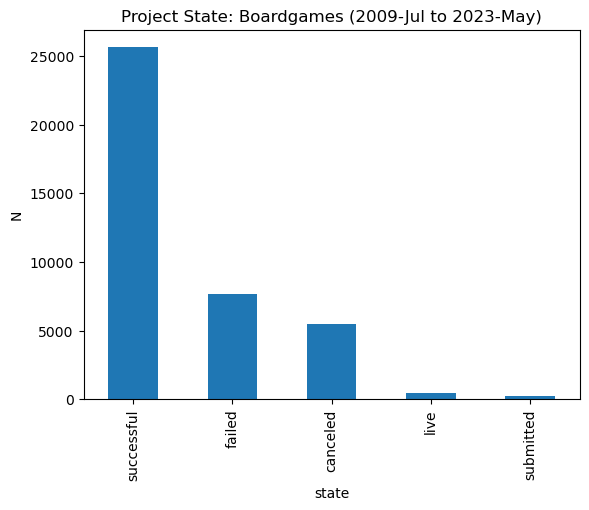

In [74]:
y_m = cleaned.launched_at.dropna().convert_dtypes().dt.strftime('%Y-%b')
cleaned.state.value_counts().plot.bar(ylabel="N",title=f"Project State: Boardgames ({y_m.min()} to {y_m.max()})")

<Axes: xlabel='num_games_per_creator', ylabel='Count'>

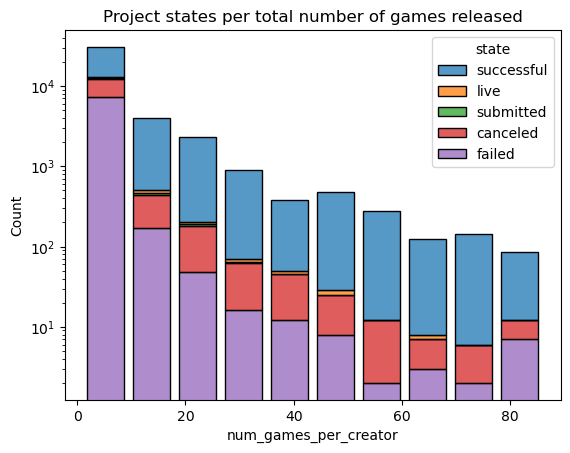

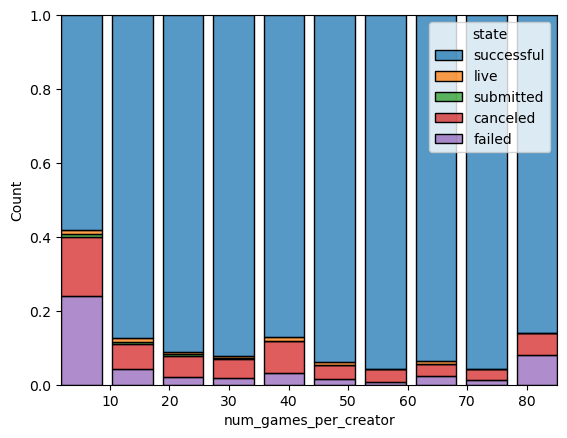

In [75]:
from itertools import chain
import seaborn as sns
from matplotlib import pyplot as plt

s = cleaned[["href","creator_id","state"]]
s.loc[:,"creator_id"] = s.creator_id.map(str)
p = s.groupby("creator_id").agg({"state":lambda x: list(chain(list(x)))}).reset_index(drop=True)
p["num_games_per_creator"]=p.state.map(len)
order = ['successful', 'live', 'submitted', 'canceled', 'failed']
ax = sns.histplot(data=p.explode("state"),bins=10,x="num_games_per_creator",stat="count",hue="state",hue_order=order,multiple="stack",shrink=0.8)
ax.set_title("Project states per total number of games released")
ax.set_yscale('log')
plt.figure()
sns.histplot(data=p.explode("state"),bins=10,x="num_games_per_creator",hue="state",hue_order=order,multiple="fill",shrink=0.8)


In [76]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

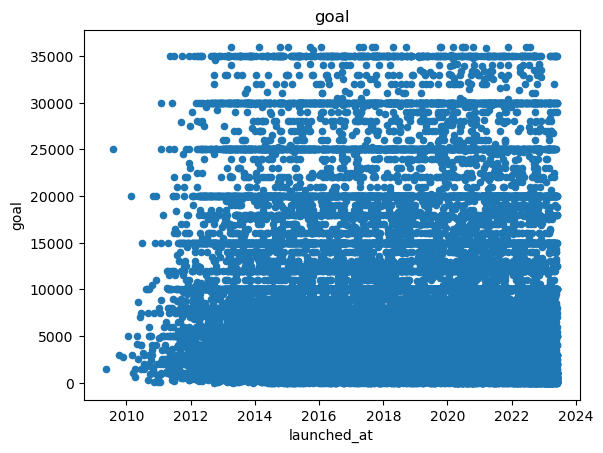

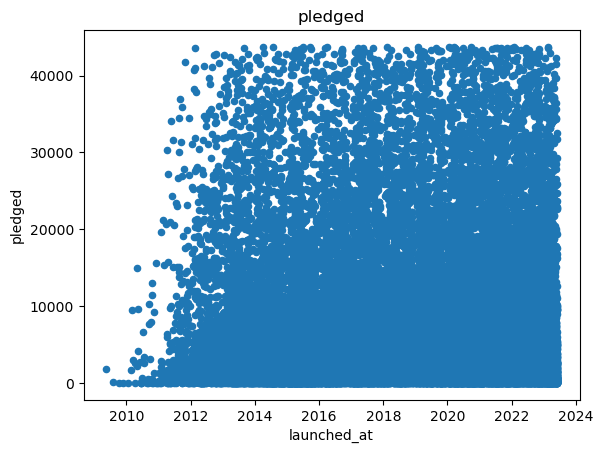

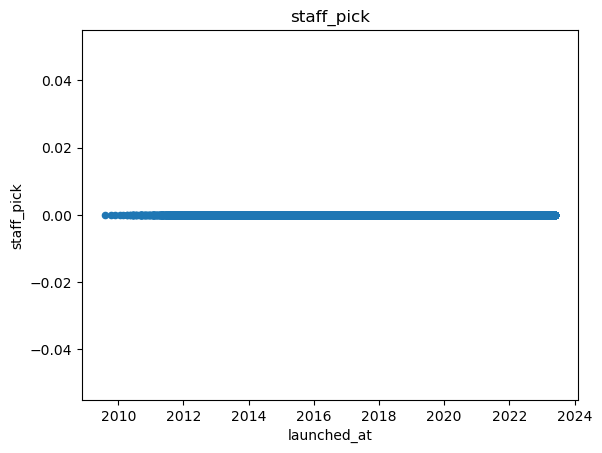

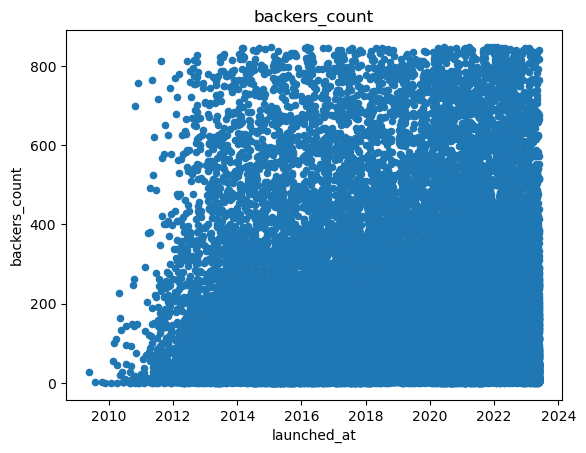

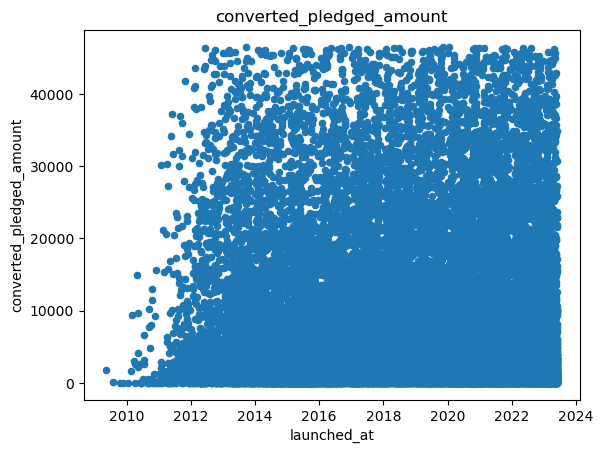

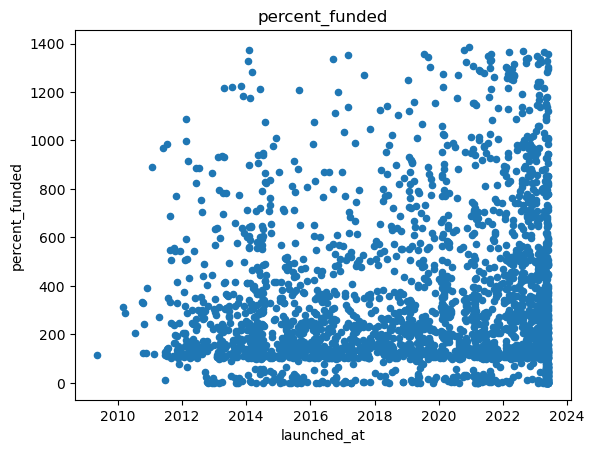

In [77]:
for c in numeric_subset:
    if c in dates:
        continue
    mask = Remove_Outlier_Indices(cleaned[c])
    cleaned[mask].dropna(subset="launched_at").plot(x="launched_at",y=c,title=c,kind="scatter")

In [78]:
import numpy as np
def to_float(x):
    try:
        return float(x)
    except:
        return np.nan

In [79]:
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
from collections import defaultdict
import pycountry

#counts_per_country = cleaned[cleaned.launched_at < pd.to_datetime("01/01/2012")].country.value_counts().reset_index()
counts_per_country = cleaned.country.value_counts().reset_index()
counts_per_country.country = counts_per_country.country.map(defaultdict(**{country.alpha_2:country.alpha_3 for country in pycountry.countries},))
counts_per_country

,country,count
0,USA,24194
1,GBR,4991
2,CAN,1951
3,ESP,1277
4,ITA,1106
5,AUS,1020
6,DEU,975
7,FRA,758
8,NLD,445
9,MEX,445


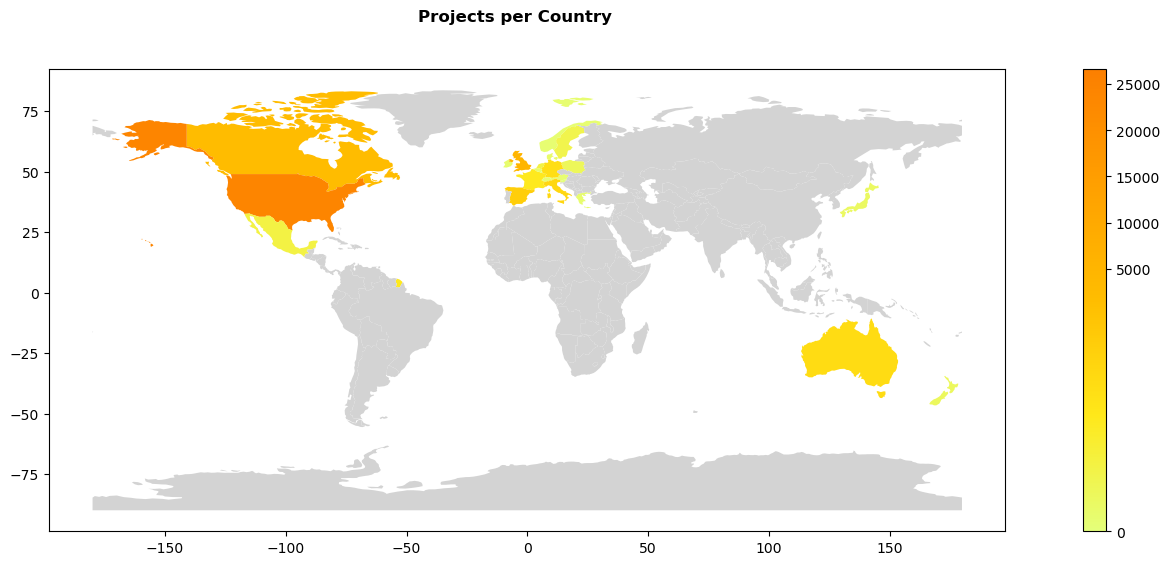

In [80]:
import geopandas as gpd
import numpy as np
from matplotlib.colors import TwoSlopeNorm

vmin,vmax,vcenter = 0,counts_per_country["count"].max()*1.1,counts_per_country["count"].mean()

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries = countries.merge(counts_per_country,how="left",left_on="iso_a3",right_on="country").drop(columns="country")

countries["count"] = countries["count"].map(to_float)

fig, ax = plt.subplots(figsize = (20,6))
fig.suptitle('Projects per Country',
             fontsize = 'large',  
             fontweight = 'bold')
cmap = 'Wistia'
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
pc = countries.plot(column="count",cmap=cmap,norm=norm,legend=False,ax=ax,missing_kwds={'color': 'lightgrey'})
fig.colorbar(cbar, ax=ax)

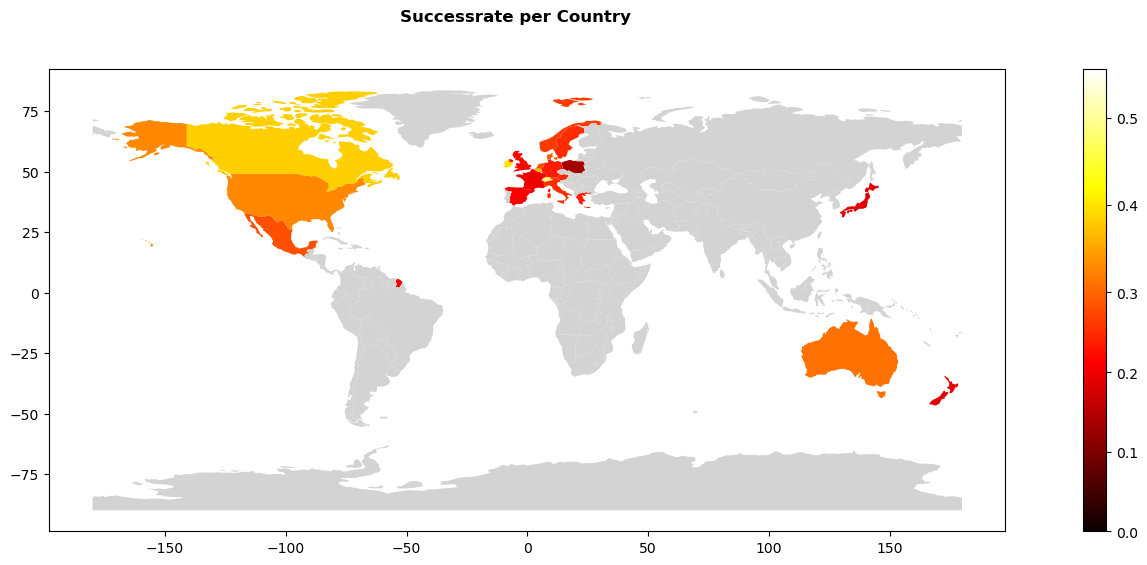

In [81]:
failed_per_country = cleaned[cleaned.state=="failed"].country.value_counts()
successful_per_country = cleaned[cleaned.state=="successful"].country.value_counts()
counts_per_country = (failed_per_country/successful_per_country).dropna().reset_index()
counts_per_country.country = counts_per_country.country.map(defaultdict(**{country.alpha_2:country.alpha_3 for country in pycountry.countries},))

vmin,vmax,vcenter = 0,counts_per_country["count"].max(),counts_per_country["count"].mean()

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries = countries.merge(counts_per_country,how="left",left_on="iso_a3",right_on="country").drop(columns="country")

countries["count"] = countries["count"].map(to_float)

fig, ax = plt.subplots(figsize = (20,6))
fig.suptitle('Successrate per Country',
             fontsize = 'large',  
             fontweight = 'bold')
cmap = 'hot'
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
pc = countries.plot(column="count",cmap=cmap,norm=norm,legend=False,ax=ax,missing_kwds={'color': 'lightgrey'})
fig.colorbar(cbar, ax=ax)

<h1>Further Analysis

In [82]:
# predictor of success OLS

In [83]:
# relate avg-sentiment pre-funding comments with output success

In [84]:
# group/ align with BGG category data